In [12]:
## RUN THIS CELL TO GET THE RIGHT FORMATTING AND TO LOAD NumPy
import requests
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

<div class="exercise"><b>Write a function to determine some interesting facts about the provided actor/actress.</b></div> 

Write a Python function called analyzeActor(dbcon, actor_name) that will perform appropriate SQL queries (to the database with the connection dbcon) to determine some interesting facts about the provided actor/actress. Your function must use sqlalchemy, not sql magic). Specifically, the function should only examine movies and display the following information:
- The first appearance of the actor (title of movie, year the movie premiered, the character the actor played, and the age of the actor at that time).
- The last appearance of the actor (title of movie, year the movie premiered, the character the actor played, and the age of the actor at that time).
- The actor’s lowest rated movie.
- The actor’s highest rated movie.
- A line graph of the number of movies the actor was involved in for each year over their career.

**Run the code cell below to establish the connection to the `imdb` database using the connection string `cstring` using sqlite. However, remember to import necessary Python libraries such as sqlalchemy and pandas first!**

In [13]:
import sqlalchemy as sa
import pandas as pd
cstring = "sqlite+pysqlite:///imdb.db"
engine = sa.create_engine(cstring)
connection = engine.connect()

**We should define our function to analyze data now.**

Let's breakdown our super function into smaller steps! First of all we should notice that there must be at least two queries inside this function:
- Query 1: Extract the information about the actor's first and last movie, his/her age and movie character at these times, and his/her lowest and highest rated movie.
- Query 2: Extract the number of movies the actor was involved in for each year.

In [14]:
# define a function
def analyzeActor(dbcon, actor_name):
    # write the first query using basic SQL statements and assign it to variable pyquery 
    pyquery = '''
    SELECT T2.title_id, T2.primary_title, T2.premiered, T2.name, T2.age, T2.characters, rating
    FROM (SELECT title_id, primary_title, premiered, T1.name, (premiered-T1.born) AS age, characters
    FROM (SELECT person_id, name, born, title_id, characters
    FROM people
    INNER JOIN crew
    USING (person_id)
    WHERE name = :name AND born IS NOT NULL) AS T1
    INNER JOIN titles
    USING (title_id)
    WHERE premiered IS NOT NULL AND titles.type = 'movie'
    GROUP BY premiered) AS T2
    LEFT JOIN ratings
    USING (title_id)
    ORDER BY T2.age
    '''
    
    # write the second query using basic SQL statements and assign it to variable pyquery2
    pyquery2 = '''SELECT COUNT(primary_title) AS title_count, premiered
    FROM (SELECT person_id, name, born, title_id, characters
    FROM people
    INNER JOIN crew
    USING (person_id)
    WHERE name = :name AND born IS NOT NULL) AS T1
    INNER JOIN titles
    USING (title_id)
    WHERE premiered IS NOT NULL AND titles.type = 'movie'
    GROUP BY premiered'''
    
    # use pyquery with a bind operation to create a dataframe df
    prepare_stmt = sa.sql.text(pyquery)
    bound_stmt = prepare_stmt.bindparams(name = actor_name)
    df = pd.read_sql_query(bound_stmt, con = dbcon)
    
    # use pyquery2 with a bind operation to create a dataframe df2
    prepare_stmt2 = sa.sql.text(pyquery2)
    bound_stmt2 = prepare_stmt2.bindparams(name = actor_name)
    df2 = pd.read_sql_query(bound_stmt2, con = dbcon)
    
    return df.head(10), df2.head(10)

**Let's see what we have so far in our function by running the code below with our analysis of an actor named Warren Beatty.**

In [15]:
df1, df2 = analyzeActor(connection, 'Warren Beatty')
display(df1, df2)

,title_id,primary_title,premiered,name,age,characters,rating
0,tt0055382,The Roman Spring of Mrs. Stone,1961,Warren Beatty,24,"[""Paolo di Leo""]",6.5
1,tt0055738,All Fall Down,1962,Warren Beatty,25,"[""Berry-Berry Willart""]",6.8
2,tt0058294,Lilith,1964,Warren Beatty,27,"[""Vincent Bruce""]",6.9
3,tt0059447,Mickey One,1965,Warren Beatty,28,"[""Mickey""]",6.4
4,tt0060581,Kaleidoscope,1966,Warren Beatty,29,"[""Barney Lincoln""]",6.0
5,tt0061418,Bonnie and Clyde,1967,Warren Beatty,30,"[""Clyde Barrow""]",7.8
6,tt0066184,The Only Game in Town,1970,Warren Beatty,33,"[""Joe Grady""]",5.7
7,tt0067411,McCabe & Mrs. Miller,1971,Warren Beatty,34,"[""John McCabe""]",7.6
8,tt0071970,The Parallax View,1974,Warren Beatty,37,"[""Joseph Frady""]",7.1
9,tt0073008,The Fortune,1975,Warren Beatty,38,"[""Nicky Wilson""]",5.7


,title_count,premiered
0,2,1961
1,1,1962
2,1,1964
3,1,1965
4,2,1966
5,1,1967
6,1,1970
7,2,1971
8,1,1974
9,2,1975


Wow, that's kinda cool! We now get all the information we need. The only thing that we need to do right now is to clean some parts of the dataframe, retrieve the exact data we want from these two dataframes, and display them.

In [16]:
# define a function
def analyzeActor(dbcon, actor_name):
    # write the first query using basic SQL statements and assign it to variable pyquery 
    pyquery = '''
    SELECT T2.title_id, T2.primary_title, T2.premiered, T2.name, T2.age, T2.characters, rating
    FROM (SELECT title_id, primary_title, premiered, T1.name, (premiered-T1.born) AS age, characters
    FROM (SELECT person_id, name, born, title_id, characters
    FROM people
    INNER JOIN crew
    USING (person_id)
    WHERE name = :name AND born IS NOT NULL) AS T1
    INNER JOIN titles
    USING (title_id)
    WHERE premiered IS NOT NULL AND titles.type = 'movie'
    GROUP BY premiered) AS T2
    LEFT JOIN ratings
    USING (title_id)
    ORDER BY T2.age
    '''
    
    # write the second query using basic SQL statements and assign it to variable pyquery2 
    pyquery2 = '''SELECT COUNT(primary_title) AS title_count, premiered
    FROM (SELECT person_id, name, born, title_id, characters
    FROM people
    INNER JOIN crew
    USING (person_id)
    WHERE name = :name AND born IS NOT NULL) AS T1
    INNER JOIN titles
    USING (title_id)
    WHERE premiered IS NOT NULL AND titles.type = 'movie'
    GROUP BY premiered'''
    
    # use pyquery with a bind operation to create a dataframe df
    prepare_stmt = sa.sql.text(pyquery)
    bound_stmt = prepare_stmt.bindparams(name = actor_name)
    df = pd.read_sql_query(bound_stmt, con = dbcon)
    
    # use lambda function to clean the text
    to_clean = lambda s: s[2:-2]
    
    # apply to_clean function to clean the characters column of the dataframe df
    df["characters"] = df["characters"].apply(to_clean)
    
    # use basic dataframe operation to get the rows of the actor's first and last appearances
    first_ap = df[df.age == df.age.min()]
    last_ap = df[df.age == df.age.max()]
    
    # use basic dataframe operation to get the rows of the actor's lowest and highest appearances
    min_rate = df[df.rating == df.rating.min()]
    max_rate = df[df.rating == df.rating.max()]
    
    # use pyquery2 with a bind operation to create a dataframe df2
    prepare_stmt2 = sa.sql.text(pyquery2)
    bound_stmt2 = prepare_stmt2.bindparams(name = actor_name)
    df2 = pd.read_sql_query(bound_stmt2, con = dbcon)
    
    # use print statements to display our data
    print("=================================================")
    print("Actor:", actor_name)
    print("=================================================")
    print()
    print("First appearance:")
    print("=================")
    print(str(first_ap.iloc[0,2]) + ": Played " + str(first_ap.iloc[0,5]) + " in '" + str(first_ap.iloc[0,1]) + "' (at age " + str(first_ap.iloc[0,4]) + ")")
    print()
    print("Last appearance:")
    print("=================")
    print(str(last_ap.iloc[0,2]) + ": Played " + str(last_ap.iloc[0,5]) + " in '" + str(last_ap.iloc[0,1]) + "' (at age " + str(last_ap.iloc[0,4]) + ")")
    print()
    print("Lowest rated movie: " + str(min_rate.iloc[0,1]) + " (rating = " + str(min_rate.iloc[0,6]) + ")") 
    print("Highest rated movie: " + str(max_rate.iloc[0,1]) + " (rating = " + str(max_rate.iloc[0,6]) + ")") 
    
    # use plot() function from matplotlib to create a graph showing the number of movies per year of the actor
    plt.plot(df2["premiered"], df2["title_count"])
    plt.title("Numer of Movies Per Year")
    plt.xlabel("Year")
    plt.ylabel("Number of Movies")
    plt.show()

**Run the code below to test our function with Warren Beatty.**

Actor: Warren Beatty

First appearance:
1961: Played Paolo di Leo in 'The Roman Spring of Mrs. Stone' (at age 24)

Last appearance:
2021: Played Self in 'Live at Mister Kelly's' (at age 84)

Lowest rated movie: Town & Country (rating = 4.5)
Highest rated movie: Live at Mister Kelly's (rating = 8.3)


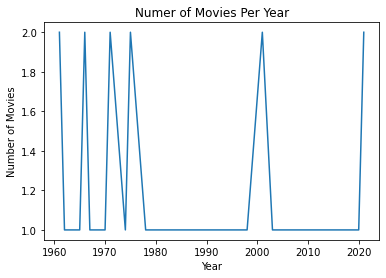

In [17]:
analyzeActor(connection, 'Warren Beatty')

It seems like we have done a great job in analyzing Warren Beatty's career life! She has spent most of her life acting and got a great recognition from the audience. Let's now look at Tom Cruise's acting life.

Actor: Tom Cruise

First appearance:
1982: Played Woody in 'Losin' It' (at age 20)

Last appearance:
2024: Played Ethan Hunt in 'Mission: Impossible 8' (at age 62)

Lowest rated movie: Losin' It (rating = 4.9)
Highest rated movie: Success Formula (rating = 9.9)


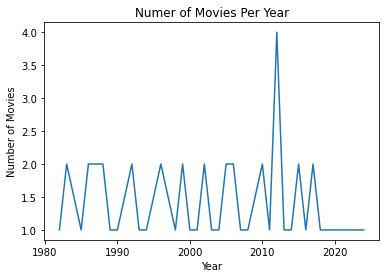

In [18]:
analyzeActor(connection, 'Tom Cruise')

It's amazing! Tom Cruise got the nearly perfect rating with a movie called "Success Formula". Moreover, 2011 was his acting year that has the highest number of movies he participated. As you can see, we can see a lot of insights with this super cool function. 

<div class="exercise"><b>Write a function to test the correlation between the rating and the number of regions one title is streamed.</b></div> 
One thing we should investigate in the imdb database is the relationship between the rating of the title and its number of streaming regions. We can examine this relationship among different types of titles including movie, video game, short film, TV series, etc. My hypothesis is that the more regions the title is streamed, the higher rating it will get. 

**We now start our function with the simple query.**

In [19]:
# define a function
def rate_region(dbcon):
    # write a query to extract needed information
    query = '''SELECT title_id, region_num, rating, votes
    FROM (SELECT title_id, COUNT(region) AS region_num
    FROM akas
    GROUP BY title_id) AS T
    INNER JOIN ratings
    USING (title_id)
    ORDER BY rating DESC'''
    
    # use execute method with the defined query to have the result proxy
    result_proxy = dbcon.execute(query)
    
    # use fetchall method on the result proxy object to get the result list
    result_list = result_proxy.fetchall()
    
    # use DataFrame method of pandas to get the dataframe from the result list
    df = pd.DataFrame(result_list, columns = result_proxy.keys())
    
    # print the number of records of the dataframe
    print("Number of records:", len(df))
    return df.head(15)

rate_region(connection)

Number of records: 913268


,title_id,region_num,rating,votes
0,tt0050536,1,10.0,13
1,tt0056535,1,10.0,13
2,tt0061857,1,10.0,10
3,tt0111263,1,10.0,7
4,tt0116083,1,10.0,46
5,tt0132596,1,10.0,12
6,tt0140082,1,10.0,19
7,tt0160316,1,10.0,14
8,tt0176240,1,10.0,6
9,tt0193147,1,10.0,6


Let's take a few minutes to look through our result. Wow... we have a lot of records (which we have to cut to optimize our function) and a result that is kind of opposite to our hypothesis. Also, it does take us a few seconds longer than normal to run the above code, which means that the database is large and the analysis is kind of hard to operate. There are number of things we should consider:
- The query should focus on one type only.
- The query should filter rows where the title is rated with the number of votes being equal or larger than the average number of votes.

In [20]:
# define a function
def rate_region(dbcon, title_type):
    # write a query using basic SQL statements and assign it to variable pyquery 
    pyquery = '''
    SELECT title_id, region_num, rating, votes
    FROM (SELECT title_id, region_num
    FROM (SELECT title_id, COUNT(region) AS region_num
    FROM akas
    GROUP BY title_id) AS T
    INNER JOIN titles
    USING (title_id)
    WHERE type = :tit_type) AS T1
    INNER JOIN ratings
    USING (title_id)
    WHERE (votes > (SELECT AVG(votes)
    FROM ratings))
    ORDER BY rating DESC'''
    
    # use pyquery with a bind operation to create a dataframe df
    prepare_stmt = sa.sql.text(pyquery)
    bound_stmt = prepare_stmt.bindparams(tit_type = title_type)
    df = pd.read_sql_query(bound_stmt, con = dbcon)
    
    # print the number of records of the dataframe
    print("Number of records:", len(df))
    return df.head(15)

In [21]:
rate_region(connection, "movie")

Number of records: 37058


,title_id,region_num,rating,votes
0,tt16228146,4,10.0,4433
1,tt13440294,6,9.9,2010
2,tt16747572,9,9.9,8662
3,tt11379988,9,9.8,4975
4,tt7400974,2,9.8,2513
5,tt14923112,11,9.7,8666
6,tt15891800,2,9.7,1021
7,tt16258162,3,9.7,1084
8,tt16292898,2,9.7,1020
9,tt9794412,6,9.6,1343


Here it is! The dataframe now looks more neat and may have what we need for analysis. Let's turn it into a scatter plot to see the correlation more clear. 

**Insert the scatter plot into the function.**

In [22]:
# define a function
def rate_region(dbcon, title_type):
    # write a query using basic SQL statements and assign it to variable pyquery 
    pyquery = '''
    SELECT title_id, region_num, rating, votes
    FROM (SELECT title_id, region_num
    FROM (SELECT title_id, COUNT(region) AS region_num
    FROM akas
    GROUP BY title_id) AS T
    INNER JOIN titles
    USING (title_id)
    WHERE type = :tit_type) AS T1
    INNER JOIN ratings
    USING (title_id)
    WHERE (votes > (SELECT AVG(votes)
    FROM ratings))
    ORDER BY rating DESC'''
    
    # use pyquery with a bind operation to create a dataframe df
    prepare_stmt = sa.sql.text(pyquery)
    bound_stmt = prepare_stmt.bindparams(tit_type = title_type)
    df = pd.read_sql_query(bound_stmt, con = dbcon)
    
    # use scatter method of matplotlib library to draw a scatter plot
    plt.scatter(df["rating"], df["region_num"])
    plt.title("Scatter plot of Rating vs. Number of regions that the title is streamed")
    plt.xlabel("Rating")
    plt.ylabel("Number of regions")
    plt.show

**Run the code below to test our function with movie type.**

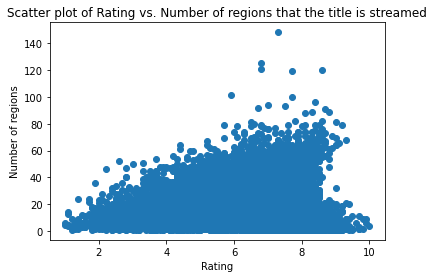

In [23]:
rate_region(connection, "movie")

Hmmm... Never see any scatter plot like this before? Me too. Shall we try another type? 

**Run the code below to test our function with short film type.**

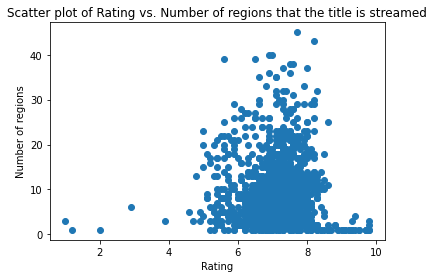

In [24]:
rate_region(connection, "short")

Interesting. You may notice that there is no trend shown in the scatter plot. It is vague to conclude that whether there is a clear correlation or not.

**Run the code below to patiently test one more type: TV series.**

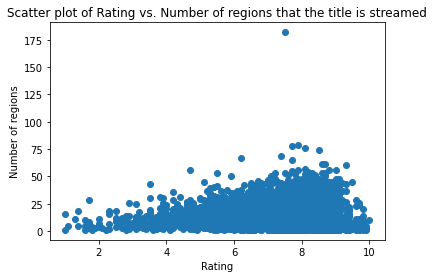

In [25]:
rate_region(connection, "tvSeries")

From these graphs, we can notice that there is no such a correlation between rating and the number of regions a title is streamed. However, it seems like there is always one outlier in each graph that shows the rating being around 8 with the highest number of streaming regions.

<div class="exercise"><b>Write a function to check the popularity of a specific genre of movies and get the top 3 recommended movies for that genre.</b></div> 
With the movie database, we can analyze a lot of interesting things which help us to diversify our movie list as well! With the current database, we can examine the popularity of one specific genre at that time. After getting the insights of the genre, we can also get the top 3 recommended movies of that genre. 

**Let's first define a function and write simple queries**

In [26]:
# define a function
def genre_examine(dbcon, genre):
    # write the first query to extract the total number of records which have genres
    query1 = '''
    SELECT COUNT(DISTINCT title_id) AS total
    FROM (SELECT title_id, genres 
    FROM titles 
    WHERE type = 'movie' AND genres <> '\\N')
    '''
    
    # write the second query to extract the total number of records which have the specified genre
    template = """
    SELECT COUNT(DISTINCT title_id) AS specified_records
    FROM titles
    WHERE type = 'movie' AND genres LIKE '%{}%'
    """
    
    # use format() method to create a complete query
    query2 = template.format(genre)
    
    # use execute method with the defined queries to have the result proxies
    result_proxy = dbcon.execute(query1)
    result_proxy2 = dbcon.execute(query2)
    
    # use fetchall method on the result proxy objects to get the result lists
    result_list = result_proxy.fetchall()
    result_list2 = result_proxy2.fetchall()
    
    # use DataFrame method of pandas to get the dataframes from the result lists
    df = pd.DataFrame(result_list, columns = result_proxy.keys())
    df2 = pd.DataFrame(result_list2, columns = result_proxy2.keys())
    
    return df, df2

In [27]:
df, df2 = genre_examine(connection, "Horror")
display(df, df2)

,total
0,534211


,specified_records
0,33612


Hmmm it seems like we can improve the code by combining these two queries into one only to get the percentage showing the popularity of one specific genre.

In [28]:
# define a function
def genre_examine(dbcon, genre):
    # write the template to extract the distribution of a specified genre
    template = '''SELECT (1.0 * COUNT(DISTINCT title_id) / (SELECT COUNT(title_id) 
    FROM (SELECT title_id, genres 
    FROM titles 
    WHERE type = 'movie' AND genres <> '\\N')))*100 AS percentage
    FROM titles
    WHERE type = 'movie' AND genres LIKE '%{}%'
    '''
    
    # use format() method to create a complete query
    query = template.format(genre)
    
    # use execute method with the defined query to have the result proxy
    result_proxy = dbcon.execute(query)
    
    # use fetchall method on the result proxy object to get the result list
    result_list = result_proxy.fetchall()
    
    # use DataFrame method of pandas to get the dataframe from the result list
    df = pd.DataFrame(result_list, columns = result_proxy.keys())
    print("The distribution of the", genre, "genre is", str(round(df.iloc[0,0],3))+"%.")

genre_examine(connection, "Horror")

The distribution of the Horror genre is 6.292%.


From this, we now have a report of the popularity of the genre that we want to examine. Okay, let's work on the second part where we want to recommend the user top 3 movies from that genre.

In [ ]:
# define a function
def genre_examine(dbcon, genre):
    # write the first template to extract the distribution of a specified genre
    template1 = '''SELECT (1.0 * COUNT(DISTINCT title_id) / (SELECT COUNT(title_id) 
    FROM (SELECT title_id, genres 
    FROM titles 
    WHERE type = 'movie' AND genres <> '\\N')))*100 AS percentage
    FROM titles
    WHERE type = 'movie' AND genres LIKE '%{}%'
    '''
    
    # write the second template to get the top 3 rated movies of a specified genre
    template2 = '''SELECT DISTINCT primary_title AS title, name AS director, premiered, rating
    FROM (SELECT name, primary_title, title_id, premiered
    FROM (SELECT name, title_id
    FROM people
    INNER JOIN crew
    USING (person_id)
    WHERE category = 'director') AS T1
    INNER JOIN titles
    USING (title_id)
    WHERE type = 'movie' AND genres LIKE '%{}%') AS T2
    INNER JOIN ratings
    USING (title_id)
    WHERE (votes > (SELECT AVG(votes)
    FROM ratings))
    ORDER BY rating DESC
    LIMIT 3
    '''
    
    # use format() method to create complete queries
    query1 = template1.format(genre)
    query2 = template2.format(genre)
    
    # use execute method with the defined queries to have the result proxies
    result_proxy1 = dbcon.execute(query1)
    result_proxy2 = dbcon.execute(query2)
    
    # use fetchall method on the result proxy objects to get the result lists
    result_list1 = result_proxy1.fetchall()
    result_list2 = result_proxy2.fetchall()
    
    # use DataFrame method of pandas to get the dataframes from the result lists
    df1 = pd.DataFrame(result_list1, columns = result_proxy1.keys())
    df2 = pd.DataFrame(result_list2, columns = result_proxy2.keys())
    print("The distribution of the", genre, "genre is", str(round(df1.iloc[0,0],3))+"%.")
    return df2

In [29]:
genre_examine(connection, "Horror")

The distribution of the Horror genre is 6.292%.


We now have everything! Let's edit the function so it can be more interactive.

In [30]:
# define a function
def genre_examine(dbcon, genre):
    # write the first template to extract the distribution of a specified genre
    template1 = '''SELECT (1.0 * COUNT(DISTINCT title_id) / (SELECT COUNT(title_id) 
    FROM (SELECT title_id, genres 
    FROM titles 
    WHERE type = 'movie' AND genres <> '\\N')))*100 AS percentage
    FROM titles
    WHERE type = 'movie' AND genres LIKE '%{}%'
    '''
    
    # write the second template to get the top 3 rated movies of a specified genre
    template2 = '''SELECT DISTINCT primary_title AS title, name AS director, premiered, rating
    FROM (SELECT name, primary_title, title_id, premiered
    FROM (SELECT name, title_id
    FROM people
    INNER JOIN crew
    USING (person_id)
    WHERE category = 'director') AS T1
    INNER JOIN titles
    USING (title_id)
    WHERE type = 'movie' AND genres LIKE '%{}%') AS T2
    INNER JOIN ratings
    USING (title_id)
    WHERE (votes > (SELECT AVG(votes)
    FROM ratings))
    ORDER BY rating DESC
    LIMIT 3
    '''
    
    # use format() method to create complete queries
    query1 = template1.format(genre)
    query2 = template2.format(genre)
    
    # use execute method with the defined queries to have the result proxies
    result_proxy1 = dbcon.execute(query1)
    result_proxy2 = dbcon.execute(query2)
    
    # use fetchall method on the result proxy objects to get the result lists
    result_list1 = result_proxy1.fetchall()
    result_list2 = result_proxy2.fetchall()
    
    # use DataFrame method of pandas to get the dataframes from the result lists
    df1 = pd.DataFrame(result_list1, columns = result_proxy1.keys())
    df2 = pd.DataFrame(result_list2, columns = result_proxy2.keys())
    print("The distribution of the", genre, "genre is", str(round(df1.iloc[0,0],3))+"%.")
    print("Top 3 " + genre + " movies recommended for you are:")
    print("------------")
    for i in range(len(df2)):
        print(str(i+1) + ". " + df2.loc[i, "title"] + " (" + str(df2.loc[i, "premiered"]) + ") directed by " + df2.loc[i, "director"] + " and rated " + str(df2.loc[i, "rating"]) + ".")

**Run the code below to test our function with Horror genre**

In [31]:
genre_examine(connection, "Horror")

The distribution of the Horror genre is 6.292%.
Top 3 Horror movies recommended for you are:
------------
1. Half Stories (2022) directed by Siva Kesanakurthi and rated 9.3.
2. Shhh! (1993) directed by Upendra and rated 8.8.
3. Manichithrathazhu (1993) directed by Fazil and rated 8.7.


**Run the code below to test our function with Action genre**

In [32]:
genre_examine(connection, "Action")

The distribution of the Action genre is 9.497%.
Top 3 Action movies recommended for you are:
------------
1. James (2022) directed by Chethan Kumar and rated 9.8.
2. Katari Krishna (2021) directed by Prakash Tirumalasetty and rated 9.7.
3. Nayeem Diaries (2021) directed by Daamubalaji and rated 9.7.


**Run the code below to test our function with Romance genre**

In [33]:
genre_examine(connection, "Romance")

The distribution of the Romance genre is 8.337%.
Top 3 Romance movies recommended for you are:
------------
1. The South End (1997) directed by Riccardo DiLoreto and rated 9.5.
2. Charlie Boy (2021) directed by Timothy Hines and rated 9.4.
3. Ek Love Ya (2022) directed by Prem and rated 9.2.


After all, we should remember to close our connection to the database as well as delete the used engine to make sure all the data will not be changed.

In [34]:
connection.close()
del engine

That's interesting! There are a lot of more things that we can analyze with this big dataset. I hope the functions we have gone through here can give you useful information about the imdb database and good movie recommendation that you can watch with your family or friends.